## Dust attenuation compression
This is a notebook to demonstrate automated, ordered, independent compression of Dust attenuation curves.

In [9]:
# Imports

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.decomposition import PCA
from gplearn.genetic import SymbolicRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from librerie import*
from scipy.interpolate import interp1d

###################useful constants##################
alphab=2.6e-13
G = 6.67e-8#cgs
bi = -2.5 #UV spectral slope for MW
yr=3.154e+7#in s
#p0=numpy.array([10**4.0,10**8.0])
Msol=1.99e33#g
Lsol=3.9e33#erg/s
mp=1.66e-24#g, proton mass
kb = 1.38064852e-16#cgs
h = 6.63e-27 #ergs
c = 3e10 #cm/s
pc=3.09e18#cm
kpc=1e3*pc
To = 2.725#TCMB
Zsole=0.0142
D=1.0/163.0#dust to gas ratio MW
cost_fd=1.0
kv=3.4822*1e4#cm^2/g, MW dust Draine+03

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'librerie'

## Make example data (skip if loading from file)
Our attenuation curves will basically be an exponential curve with a Gaussian bump and some noise.

Parameters:
* lamb: exponential decay constant
* exp_off: offset of the exponential
* bump_mag: magnitude of the Gaussian bump
* bump_sigma: standard deviation of the Gaussian

Thus, you can describe this dataset in terms of 4 parameters.

Collected: 249781 valid curves.
% of valid ones -> 12.18979063979308


Text(0.5, 1.0, 'An example simulated attenuation curve')

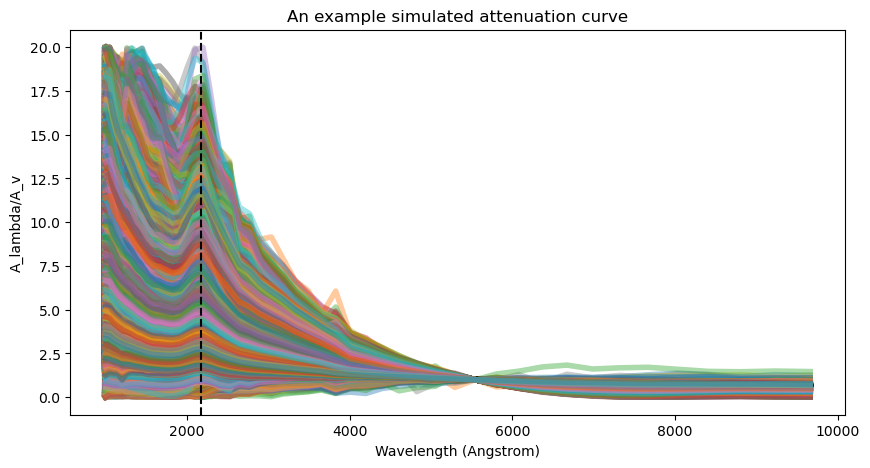

In [68]:
# --- 1. Load TNG data ---
# attenuation_curves: shape (N_galaxies, N_wavelengths)
# galaxy_props: shape (N_galaxies, N_properties)

# Load wavelength grid [micron]
wavelength = np.loadtxt('/Users/lsommovigo/Desktop/Scripts/txt_files/LTU_att_curve/wavelengths.txt')

# Load galaxy properties TNG50 and TNG100
ids_50, mstar_50, gas_mass_50, sfr_50, sfr_compact_50, gas_Z_50, rstar_50, rgas_50 = np.loadtxt(
    '/Users/lsommovigo/Desktop/Scripts/txt_files/LTU_att_curve/all_galaxy_properties_snap_93.dat',
    delimiter=',', unpack=True)
##
ids_100, mstar_100, gas_mass_100, sfr_100, sfr_compact_100, gas_Z_100, rstar_100, rgas_100 = np.loadtxt(
    '/Users/lsommovigo/Desktop/Scripts/txt_files/LTU_att_curve/tng100_all_galaxy_properties_snap_93.dat',
    delimiter=',', unpack=True)

dust_mass_50=10**gas_mass_50 * (gas_Z_50/Zsole/163.)
dust_mass_100=10**gas_mass_100 * (gas_Z_100/Zsole/163.)
sigma_SFR_50=sfr_50/(np.pi * rstar_50**2.)
sigma_SFR_100=sfr_100/(np.pi * rstar_100**2.)
sSFR_100=sfr_100/mstar_100
sSFR_50=sfr_50/mstar_50

# Combine all TNG IDs and properties into one consistent array
ids = np.concatenate([ids_50, ids_100])
properties = np.vstack([
    np.concatenate([ids_50, ids_100]),
    np.concatenate([mstar_50, mstar_100]),
    np.concatenate([gas_mass_50, gas_mass_100]),
    np.concatenate([sfr_50, sfr_100]),
    np.concatenate([sfr_compact_50, sfr_compact_100]),
    np.concatenate([gas_Z_50, gas_Z_100]),
    np.concatenate([rstar_50, rstar_100]),
    np.concatenate([rgas_50, rgas_100]),
    np.concatenate([dust_mass_50, dust_mass_100]),
    np.concatenate([sigma_SFR_50, sigma_SFR_100]),
    np.concatenate([sSFR_50, sSFR_100])
]).T  # shape: (n_galaxies, n_features)

# Paths to attenuation curves
TNG50_path = "/Users/lsommovigo/Desktop/Scripts/txt_files/LTU_att_curve/all_halos_output_snap93/output_snapnum93_shalo"
TNG100_path = "/Users/lsommovigo/Desktop/Scripts/txt_files/LTU_att_curve/TNG100_all_halos_output_snap93/output_snapnum93_shalo"

# Interpolation grid (common lambda grid)
#common_lam = np.linspace(0.1, 10., 300)

# Find index closest to V band (to normalize Att. curve)
def find_nearest(array, value):
    return np.abs(array - value).argmin()

attenuation_curves = []
galaxy_properties = []

n_los = 51  ## of los per galaxy in the SKIRT s

for i, galaxy_id in enumerate(ids):
    file_base = TNG50_path if galaxy_id in ids_50 else TNG100_path
    file_path = os.path.join(file_base + str(int(round(galaxy_id))) + '.txt')

    if not os.path.exists(file_path):
        continue

    try:
        Flux_ratio = np.loadtxt(file_path)
    except Exception:
        continue

    for ll in range(n_los):
        Fr_arr = Flux_ratio[ll]
        valid = Fr_arr > 0
        if not np.any(valid):
            continue

        lam_arr = wavelength[valid]
        Alam_arr = -2.5 * np.log10(Fr_arr[valid])

        # Normalize to A(V)
        v_index = find_nearest(lam_arr, 0.551)
        Av = Alam_arr[v_index]
        if not np.isfinite(Av) or Av == 0:
            continue
        Alam_Av_arr = Alam_arr / Av
        
        # Store results
        if len(Alam_Av_arr[lam_arr<1.])!=50:
            print('err')
        if max(Alam_Av_arr[lam_arr<1.])<20 and min(Alam_Av_arr[lam_arr<1.])>0:
            attenuation_curves.append(Alam_Av_arr[lam_arr<1.])#Alam_interp)
            galaxy_properties.append(properties[i])
        #print(properties[i][0])
        #plt.plot(1e4*lam_arr[lam_arr<1.],Alam_Av_arr[lam_arr<1.])
        #plt.show()

# Convert to numpy arrays
attenuation_curves = np.array(attenuation_curves)  # shape (n_valid_samples, n_wavelengths)
galaxy_props = np.array(galaxy_properties)    # shape (n_valid_samples, n_features)

print("Collected:", attenuation_curves.shape[0], "valid curves.")
#print('% of valid ones ->',float(attenuation_curves.shape[0])/float(len(ids)))

'''
wavelength_min = 700
wavelength_max = 9150
wavelength_bump = 2175

Nbins = 100


def simulator(params):
    lamb, exp_off, bump_mag, bump_sigma = params

    # wavelength bins
    wavelength = np.linspace(wavelength_min, wavelength_max, Nbins)

    # add a Gaussian bump
    bump = bump_mag * \
        norm.pdf(wavelength, loc=wavelength_bump, scale=bump_sigma)

    # add an exponential attenuation
    exponential = np.exp(-(wavelength - exp_off) / lamb)

    Av = bump + exponential

    # add some noise (OPTIONAL)
    Av += np.random.normal(0, 0.02, Nbins)
    return Av, wavelength


Av, wav = simulator([2000, 300, 30, 100])
'''
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axvline(x=2175, linestyle='--', c='k')

for i in range(len(attenuation_curves)):
    ax.plot(1e4*wavelength[wavelength<1], attenuation_curves[i], label='True', linewidth=4,zorder=-1000,alpha=0.4)

wav=wavelength[wavelength<1.]

ax.set(xlabel='Wavelength (Angstrom)', ylabel='A_lambda/A_v')
ax.set_title('An example simulated attenuation curve')
#plt.show()

In [69]:
'''
# Set priors
priors = [
    [700, 3000],  # lambda
    [500, 2000],    # exp_off
    [50, 500],     # bump_mag
    [50, 500],     # bump_sigma
]

N = 50_000  # Number of samples
np.random.seed(42)  # For reproducibility

# Generate random samples
params = np.random.rand(N, len(priors))
for i, prior in enumerate(priors):
    params[:, i] = params[:, i] * (prior[1] - prior[0]) + prior[0]

# Run the simulator
data = np.zeros((N, Nbins))
for i in tqdm(range(N)):
    data[i], wav = simulator(params[i])
'''

'\n# Set priors\npriors = [\n    [700, 3000],  # lambda\n    [500, 2000],    # exp_off\n    [50, 500],     # bump_mag\n    [50, 500],     # bump_sigma\n]\n\nN = 50_000  # Number of samples\nnp.random.seed(42)  # For reproducibility\n\n# Generate random samples\nparams = np.random.rand(N, len(priors))\nfor i, prior in enumerate(priors):\n    params[:, i] = params[:, i] * (prior[1] - prior[0]) + prior[0]\n\n# Run the simulator\ndata = np.zeros((N, Nbins))\nfor i in tqdm(range(N)):\n    data[i], wav = simulator(params[i])\n'

In [70]:
'''
# Plot some examples from the test set
f, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(10):
    ax.plot(wav, data[i])
ax.axvline(x=wavelength_bump, linestyle='--', c='k')

# plot range
ax.fill_between(wav, data.min(axis=0), data.max(axis=0),
                alpha=0.2, color='gray', label='Range')
ax.legend()
ax.set(xlabel='Wavelength (Angstrom)', ylabel='A_lambda/A_v')
'''

"\n# Plot some examples from the test set\nf, ax = plt.subplots(1, 1, figsize=(10, 5))\nfor i in range(10):\n    ax.plot(wav, data[i])\nax.axvline(x=wavelength_bump, linestyle='--', c='k')\n\n# plot range\nax.fill_between(wav, data.min(axis=0), data.max(axis=0),\n                alpha=0.2, color='gray', label='Range')\nax.legend()\nax.set(xlabel='Wavelength (Angstrom)', ylabel='A_lambda/A_v')\n"

## Train a neural network compressor

In [71]:
# Diagnose the trainining data, and split into train/val/test

# Run the simulor -> becomes read attenuation curves from TNG
print('Shape of data:', attenuation_curves.shape)
data=attenuation_curves
N = len(attenuation_curves)

val_frac, test_frac = 0.1, 0.1
idxs = np.arange(N)
test_idxs = np.random.choice(idxs, size=int(N*test_frac), replace=False)
remaining_idxs = np.setdiff1d(idxs, test_idxs)
val_idxs = np.random.choice(
    remaining_idxs, size=int(N*val_frac), replace=False)
train_idxs = np.setdiff1d(remaining_idxs, val_idxs)

train_data = data[train_idxs]
val_data = data[val_idxs]
test_data = data[test_idxs]

print('Train data shape:', train_data.shape)
print('Validation data shape:', val_data.shape)
print('Test data shape:', test_data.shape)

Shape of data: (249781, 50)
Train data shape: (199825, 50)
Validation data shape: (24978, 50)
Test data shape: (24978, 50)


In [72]:
# Make dataloaders

def make_dataloader(x, **kwargs):
    x = torch.tensor(x, dtype=torch.float32)
    dataset = TensorDataset(x)
    dataloader = DataLoader(dataset, **kwargs)
    return dataloader


batch_size = 64
train_loader = make_dataloader(train_data, batch_size=batch_size, shuffle=True)
val_loader = make_dataloader(val_data, batch_size=batch_size, shuffle=False)
test_loader = make_dataloader(test_data, batch_size=batch_size, shuffle=False)

In [73]:
# define the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from iobs.layers import IOBLayer


class FCN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        # Create the layers
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the layers
        x = self.model(x)
        return x


class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, features):
        # Encoder
        code = self.encoder(features)
        # Decoder
        reconstructed = self.decoder(code)
        return reconstructed


class AEIOB(nn.Module):
    def __init__(self, encoder, decoder, bottleneck):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.bottleneck = bottleneck

    def forward_neck(self, features, neck):
        # Encoder
        code = self.encoder(features)
        # Bottleneck
        code = self.bottleneck.forward_neck(code, neck)
        # Decoder
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_all(self, features):
        batch_size = features.shape[0]
        # Encoder
        encoded = self.encoder(features)
        # Bottleneck
        code = self.bottleneck.forward_all(encoded)
        code = torch.flatten(code, end_dim=1)
        # Decoder
        reconstructed = self.decoder(code)
        reconstructed = torch.unflatten(
            reconstructed, dim=0, sizes=(batch_size, -1))
        return reconstructed, encoded

    def encode(self, features, neck):
        # Encoder
        code = self.encoder(features)
        # Bottleneck
        code = self.bottleneck.forward_neck(code, neck)
        return code

    def decode(self, code):
        # Decoder
        reconstructed = self.decoder(code)
        return reconstructed

In [74]:
input_dim = data.shape[1]  # This will be 50
hidden_dims = [64, 32, 16]
max_bottleneck = 8

encoder = FCN(input_dim, hidden_dims, max_bottleneck)
decoder = FCN(max_bottleneck, hidden_dims[::-1], input_dim)

# # Uncomment for normal autoencoder (IGNORE FOR NOW)
#model = AE(encoder, decoder)

# Uncomment for IOB autoencoder
bottleneck = IOBLayer(max_bottleneck)
model = AEIOB(encoder, decoder, bottleneck)

In [75]:
# define loss function
criterion = nn.MSELoss(reduction='mean')
code_lambda = 1  # L2 regularization on the encoding
cov_lambda = 1  # Covariance regularization


def loss_fn(model, features):
    # Forward pass
    outputs, code = model.forward_all(features)
    # Compute the MSE loss
    target = features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    # Add L2 regularization on the encoding
    loss += torch.mean(code ** 2) * code_lambda
    # Add regularization to enforce uncorrelated codes
    covariance_matrix = torch.cov(code.T)
    loss += torch.sum(covariance_matrix ** 2) * cov_lambda
    return loss, outputs, code

In [76]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss = [], []

max_epochs = 1000
patience = 10
best_val_loss = float('inf')
best_model_state = None
no_improvement_count = 0


def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch[0]
        loss, _, _ = loss_fn(model, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, return_preds=False):
    model.eval()
    total_loss = 0
    predictions = []
    codes = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0]
            loss, reconstructed, code = loss_fn(model, x)
            total_loss += loss.item() * x.size(0)
            if return_preds:
                predictions.append(reconstructed.cpu().numpy())
                codes.append(code.cpu().numpy())

    total_loss /= len(dataloader.dataset)
    if return_preds:
        predictions = np.concatenate(predictions, axis=0)
        codes = np.concatenate(codes, axis=0)
        return total_loss, predictions, codes
    else:
        return total_loss, None, None


# Training loop
pbar = tqdm(range(max_epochs))
for epoch in pbar:
    train_loss_epoch = train(model, train_loader, optimizer, loss_fn)
    val_loss_epoch, _, _ = evaluate(model, val_loader, loss_fn)

    train_loss.append(train_loss_epoch)
    val_loss.append(val_loss_epoch)

    # Update tqdm with loss values
    pbar.set_description(f"Epoch {epoch+1}/{max_epochs}")
    pbar.set_postfix({"train_loss": f"{train_loss_epoch:.3e}",
                     "val_loss": f"{val_loss_epoch:.3e}"})

    # Early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at {epoch+1} epochs")
            break

# Load the best model
model.load_state_dict(best_model_state)
model.eval()
print(f"Best validation loss: {best_val_loss:.3e}")

Epoch 22/1000:   2%| | 21/1000 [02:48<2:11:02,  8.03s/it, train_loss=3.933e-01, 

Early stopping at 22 epochs
Best validation loss: 3.903e-01


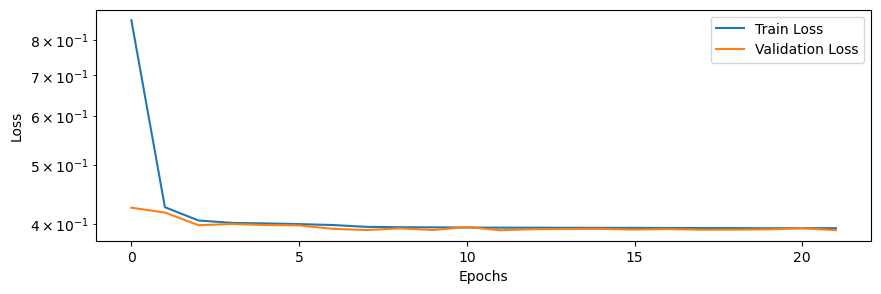

In [77]:
# Plot training and validation loss
f, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.semilogy()
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set(xlabel='Epochs', ylabel='Loss')
ax.legend()

In [78]:
# Evaluate on test set
test_loss, test_pred, test_code = evaluate(
    model, test_loader, loss_fn, return_preds=True)
print(f"Test loss: {test_loss:.3e}")

Test loss: 4.001e-01


Text(0.5, 0, 'Value')

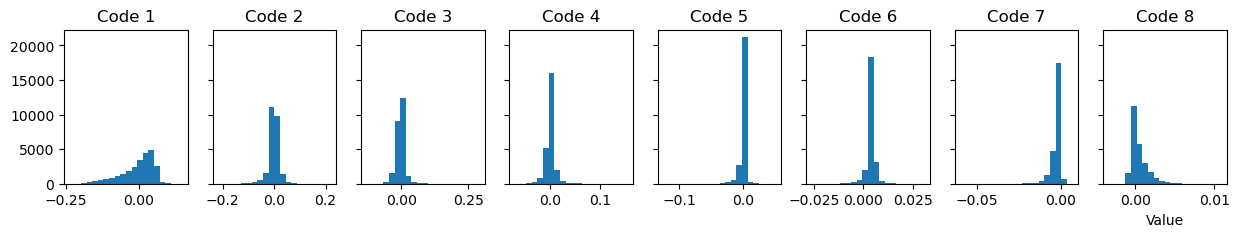

In [79]:
# Plot the distribution of encoded values

f, axs = plt.subplots(1, max_bottleneck, figsize=(15, 2), sharey=True)
for i in range(max_bottleneck):
    axs[i].hist(test_code[:, i], bins=20)
    axs[i].set_title(f'Code {i+1}')
axs[i].set_xlabel('Value')

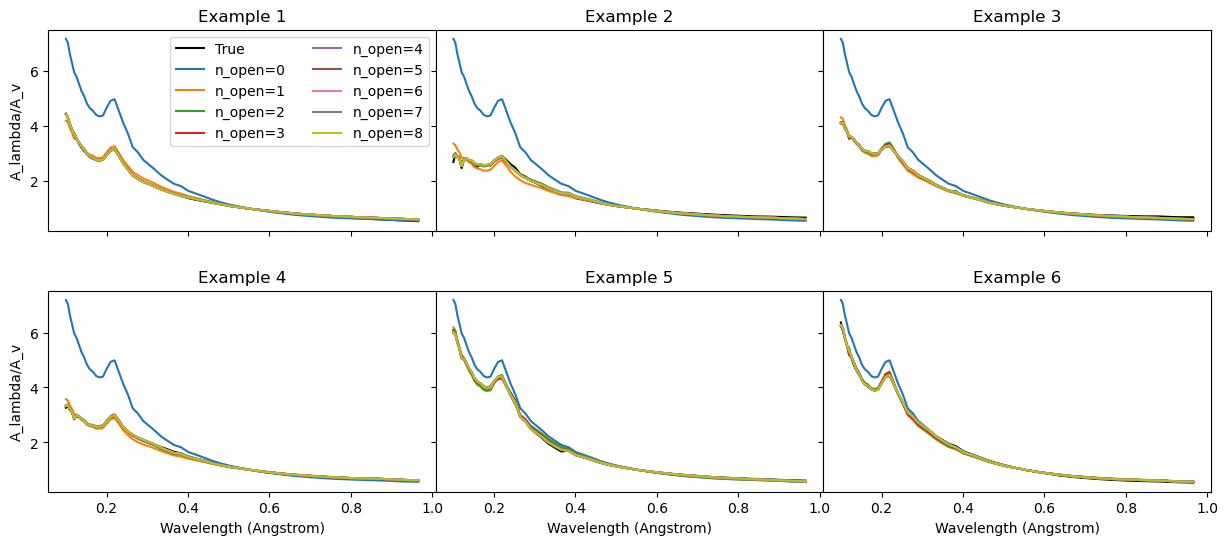

In [80]:
# Plot some examples from the test set
H, W = 2, 3
f, axs = plt.subplots(
    H, W, figsize=(W*5, H*3), sharex=True, sharey=True,
    gridspec_kw=dict(hspace=0.3, wspace=0.))
axs = axs.flatten()
for i in range(H*W):
    axs[i].plot(wav, test_data[i], label='True', c='k')
    for j in range(test_pred.shape[1]):
        axs[i].plot(wav, test_pred[i, j], label=f'n_open={j}', c=f'C{j}')
    axs[i].set_title(f"Example {i+1}")
    if i % W == 0:
        axs[i].set_ylabel('A_lambda/A_v')
    if i >= W:
        axs[i].set_xlabel('Wavelength (Angstrom)')

axs[0].legend(ncol=2)

Intrinsic Dimensionality: 4


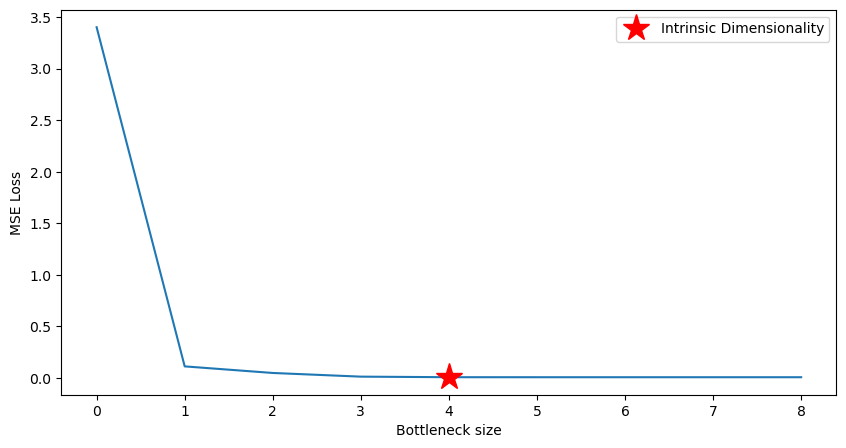

In [81]:

from scipy.stats import chi2

# Plot test loss as a function of encoding
test_loss_all = test_data[:, np.newaxis, :] - test_pred
test_loss_all = np.square(test_loss_all).mean(axis=(0, 2))

# calculate intrinisic dimensionality
p = 0.05  # p-value at which to reject the null hypothesis
test_var = np.var(test_data)
test_percerr = test_loss_all / test_var
diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(diff_loglik < chi2.isf(p, 1))[0, 0]
print(f'Intrinsic Dimensionality: {intdim}')

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(len(test_loss_all)), test_loss_all)
ax.plot(intdim, test_loss_all[intdim], 'r*',
        ms=20, label='Intrinsic Dimensionality')
ax.set(xlabel='Bottleneck size', ylabel='MSE Loss')
# ax.set_ylim(0)
ax.legend()

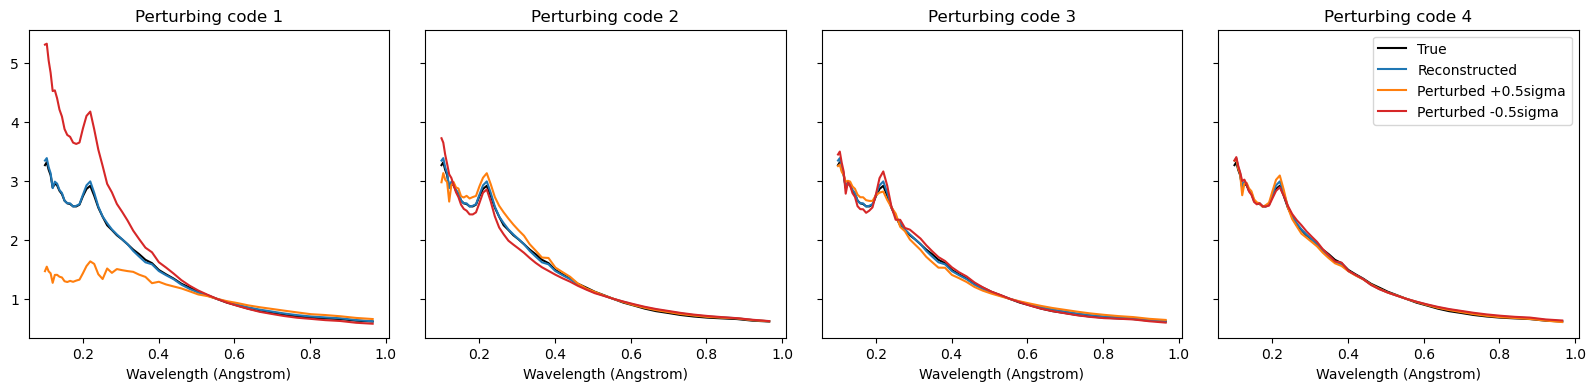

In [82]:
# Perturb the codes and see how the model performs
to_perturb = 4
perturb = 0.5

idx = 3
x = test_data[idx]
pred = test_pred[idx, to_perturb]
code = model.encode(
    torch.tensor(x, dtype=torch.float32).unsqueeze(0), neck=to_perturb)

f, axs = plt.subplots(1, to_perturb, figsize=(
    to_perturb*5, 4), sharey=True, gridspec_kw=dict(wspace=0.1))

for i, ax in enumerate(axs):
    ax.plot(wav, x, label='True', c='k')
    ax.plot(wav, pred, label='Reconstructed', c='C0')

    perturbed = code.detach().numpy().copy()
    perturbed[:, i] += perturb * test_code[:, i].std()
    perturbed = torch.tensor(perturbed, dtype=torch.float32)
    reconstructed = model.decode(perturbed).detach().numpy()
    ax.plot(wav, reconstructed[0], c='C1', label=f'Perturbed +{perturb}sigma')

    perturbed = code.detach().numpy().copy()
    perturbed[:, i] -= perturb * test_code[:, i].std()
    perturbed = torch.tensor(perturbed, dtype=torch.float32)
    reconstructed = model.decode(perturbed).detach().numpy()
    ax.plot(wav, reconstructed[0], c='C3', label=f'Perturbed -{perturb}sigma')
    ax.set_title(f'Perturbing code {i+1}')
    ax.set_xlabel('Wavelength (Angstrom)')

axs[-1].legend()